# [NTDS'17] demo 8: graph signal processing
[ntds'17]: https://github.com/mdeff/ntds_2017

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](http://lts2.epfl.ch)

For this tutorial, we'll use the [PyGSP](https://github.com/epfl-lts2/pygsp), a Python package to ease signal processing on graphs.
The PyGSP facilitates a wide variety of operations on graphs, like computing their Fourier basis, filtering or interpolating signals, plotting graphs, signals, and filters. The package includes a wide range of graphs and many filter banks. Despite all the pre-defined models, you can easily use a custom graph by defining its adjacency matrix, and a custom filter bank by defining a set of functions in the spectral domain.

You will first need to install it with `pip` or `conda`. The below code makes sure that you are installing it [in the environment in which your IPython kernel is running](https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/index.html).

In [1]:
# import sys

# conda
# !conda install --yes --prefix {sys.prefix} -c conda-forge pygsp

# pip
# !{sys.executable} -m pip install pygsp

In [2]:
%matplotlib inline

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

## 1 Graphs

For this tutorial we'll define a graph
$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\D}{\mathbf{D}}
\newcommand{\I}{\mathbf{I}}
\renewcommand{\L}{\mathbf{L}}
\newcommand{\U}{\mathbf{U}}
\newcommand{\u}{\mathbf{u}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\V}{\mathcal{V}}
\newcommand{\E}{\mathcal{E}}
\newcommand{\O}{\mathcal{O}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\g}{\hat{g}}
\DeclareMathOperator*{\argmin}{arg\,min}
\G = (\V, \E, \W)
$
as a set of nodes $\V$, a set of edges $\E$ and a weighted adjacency matrix $\W \in \R^{N \times N}$, $N = |\V|$.

Graphs are created with the [graphs module](https://pygsp.readthedocs.io/en/stable/reference/graphs.html). It includes a wide range of graphs, from point clouds like the Stanford bunny and the Swiss roll; to networks like the Minnesota road network; to models for generating random graphs like stochastic block models, sensor networks, Erdős–Rényi model, Barabási-Albert model; to simple graphs like the path, the ring, and the grid.

In [3]:
G = graphs.Minnesota()

Provided the chosen model sets coordinates for 2D or 3D plotting, the graph can be plotted with the `plot` method.

In [4]:
G.coords.shape

(2642, 2)

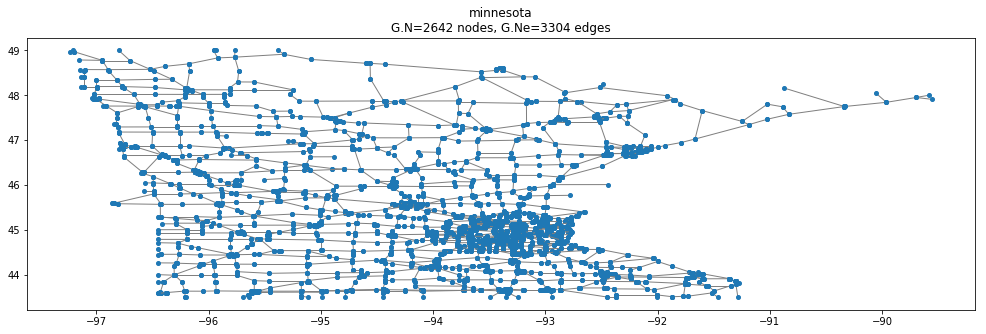

In [5]:
G.plot()

### 1.1 Custom graphs and properties

While the [graphs module](https://pygsp.readthedocs.io/en/stable/reference/graphs.html) defines many graphs, we can easily use a custom graph by defining its adjacency matrix. The alternative is to provide features from which node similarities will be computed to form a sparse adjacency matrix (see `graphs.NNGraph`).

Let's create a random weighted adjacency matrix and look at some properties.

300 nodes, 6039 edges
Connected: True
Directed: False


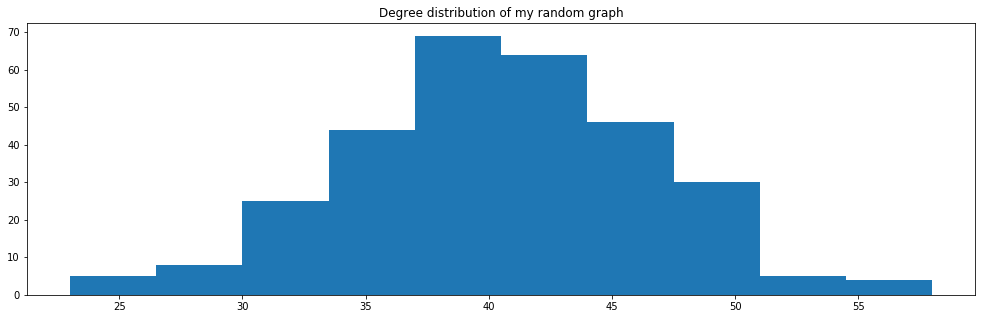

In [6]:
W = np.random.uniform(size=(300, 300))  # Full graph.
W[W < 0.93] = 0  # Sparse graph.
W = W + W.T  # Symmetric graph.
np.fill_diagonal(W, 0)  # No self-loops.

G = graphs.Graph(W)
print('{} nodes, {} edges'.format(G.N, G.Ne))

print('Connected: {}'.format(G.is_connected()))
print('Directed: {}'.format(G.is_directed()))

plt.hist(G.d)
plt.title('Degree distribution of my random graph');

Alternatively, we can construct a similarity graph $\mathbf{W} \in \mathbb{R}^{N \times N}$ from node features $\mathbf{X} = [\mathbf{x}_1, \ldots, \mathbf{x}_N]^\intercal \in \mathbb{R}^{N \times d}$ and a kernel $k(\cdot, \cdot)$, such as
$$\mathbf{W}[i,j] = k(\mathbf{x}_i, \mathbf{x}_j).$$

The kernel is often defined as the Gaussian kernel
$$k(\mathbf{x}_i, \mathbf{x}_j) = \exp \left(-\frac{d^2(\mathbf{x}_i, \mathbf{x}_j)}{\sigma^2} \right),$$
and the distance function is often an $\ell_p$-norm
$$d(\mathbf{x}_i, \mathbf{x}_j) = \| \mathbf{x}_i - \mathbf{x}_j \|_p$$
(of which the Euclidean distance is a special case with $p=2$)
or the cosine distance
$$d(\mathbf{x}_i, \mathbf{x}_j) = 1 - \frac{\langle \mathbf{x}_i, \mathbf{x}_j \rangle}{\|\mathbf{x}_i\|_2 \|\mathbf{x}_j\|_2}.$$

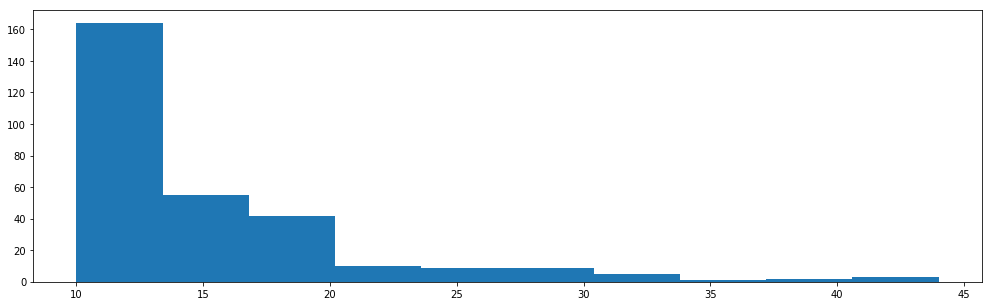

In [7]:
N, d = 300, 10
X = np.random.normal(size=(N, d))
G = graphs.NNGraph(X)
plt.hist(G.d);

### 1.2 Exercise: graph layout

Coordinates are sometimes given, e.g. if the graph is a road network as above. If it's not the case, e.g. because we just have an adjacency matrix, we must assign coordinates before plotting in 2 or 3 dimension.

A [layout method](https://en.wikipedia.org/wiki/Graph_drawing) is an algorithm to embed a graph in 2D for the purpose of drawing.

Use the `set_coordinates` method to assign a 2D coordinate to each node of the below Barabasi-Albert graph. Use two strategies:
1. place the nodes on a ring with `ring2D` and
2. use a [force-directed layout](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) with `spring`.

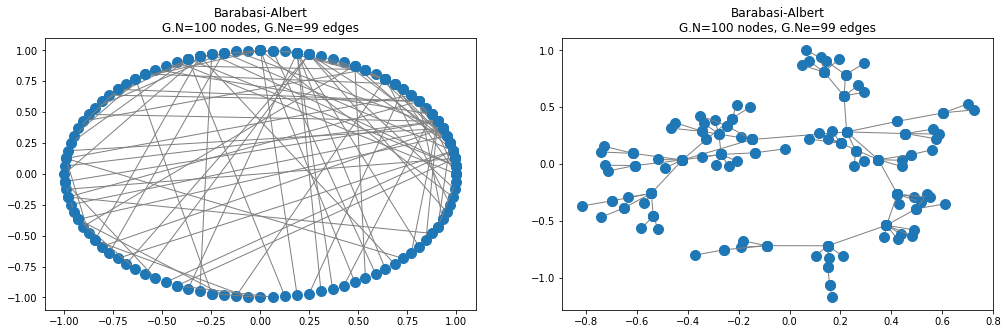

In [8]:
G = graphs.BarabasiAlbert(N=100)

fig, axes = plt.subplots(1, 2)

G.set_coordinates('ring2D')
G.plot(ax=axes[0])

G.set_coordinates('spring')
G.plot(ax=axes[1])

## 2 Laplacians

Let's create a community graph composed of `Nc=3` communities of 50, 120, and 80 nodes.

In [9]:
communities = [50, 120, 80]
G = graphs.Community(N=250, Nc=3, comm_sizes=communities, seed=1)

2017-12-12 00:27:35,751:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.8117066259517456


That graph is binary:

In [10]:
print(np.unique(G.W.toarray()))

[0 1]


We can visualize it in two ways:
1. the sparsity pattern of its adjacency matrix `G.W` and
1. its node-link diagram.

Remember, visualizing data is often insightful!

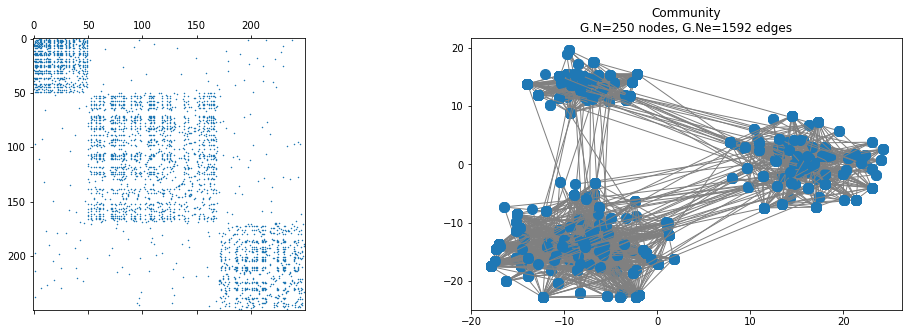

In [11]:
fig, axes = plt.subplots(1, 2)
axes[0].spy(G.W, markersize=0.5)
G.set_coordinates('community2D')
G.plot(ax=axes[1])

We can use the combinatorial Laplacian $\L = \D - \W$.

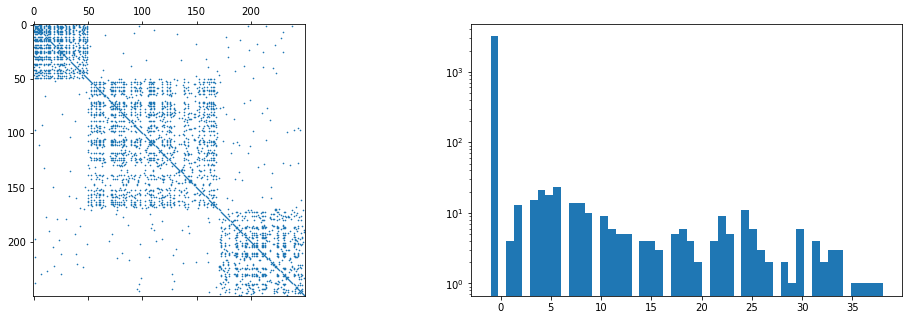

In [12]:
G.compute_laplacian('combinatorial')

fig, axes = plt.subplots(1, 2)
axes[0].spy(G.L, markersize=0.6)
axes[1].hist(G.L.data, bins=50, log=True);

Or the normalized Laplacian $\L = \I - \D^{-1/2} \W \D^{-1/2}$.

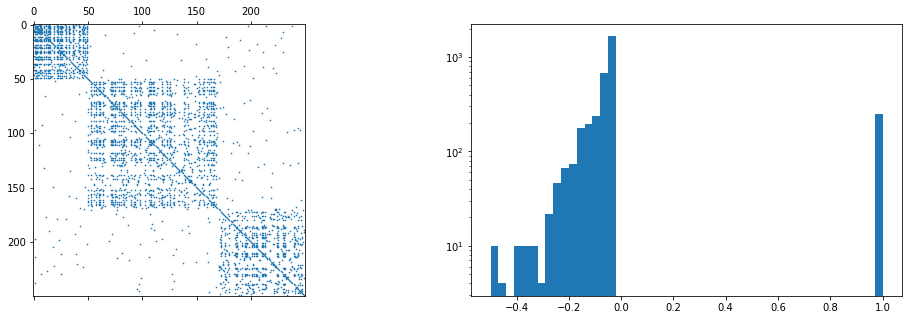

In [13]:
G.compute_laplacian('normalized')

fig, axes = plt.subplots(1, 2)
axes[0].spy(G.L, markersize=0.6)
axes[1].hist(G.L.data, bins=50, log=True);

## 3 Graph signals

A graph signal $x: \V \rightarrow \R$ can be seen as a vector $\x \in \R^N$, where $N = |\V|$ is the number of nodes.

Let's first create a random signal and visualize it on the graph.

In [14]:
x = np.random.uniform(-1, 1, size=G.N)

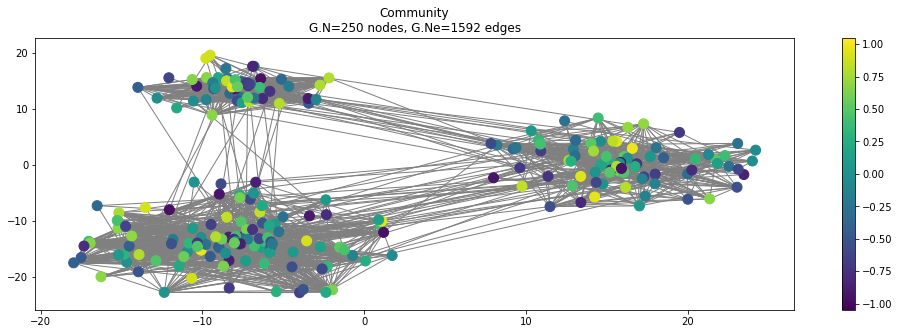

In [15]:
G.plot_signal(x)

### 3.1 Gradient and divergence

The differential operator $\D \in \R^{|\E| \times N}$ is defined such as $\L = \D^\intercal \D$. It can be computed with the PyGSP: 

In [16]:
G.compute_differential_operator()
print(G.D.shape)

(1592, 250)


The gradient of a signal $\x$ is then given by
$$\dot\x = \nabla_\G \, \x = \D \x \in \R^{|\E|}.$$

Its value on the edge $(i,j) \in \E$ is given by
$$\dot\x[(i,j)] = \sqrt{\W[i,j]} \, (\x[i] - \x[j]).$$

In [17]:
x_grad = G.D @ x

Similarly, the divergence of $\dot\x$ is given by
$$\operatorname{div} \dot\x = \D^\intercal \dot\x = \D^\intercal \D \x = \L \x \in \R^N.$$

It is a graph signal which value at node $i \in \V$ is given by
$$
\begin{align*}
(\operatorname{div} \dot\x) [i] &= \sum_{i \sim j} \sqrt{\W[i,j]} \, \dot\x[(i,j)] \\
&= \sum_{i \sim j} \W[i,j] \, (\x[i] - \x[j]) \\
&= (\L \x)[i].
\end{align*}
$$

Note that the above derivations are for the combinatorial Laplacian. For the normalized Laplacian, replace $\W$ by $\D^{-1/2} \W \D^{-1/2}$. As its name implies, the normalized Laplacian is simply a normalization of the edge weights.

In [18]:
x_div = G.D.T @ x_grad

np.linalg.norm(G.L @ x - x_div)

1.8940868840576766e-15

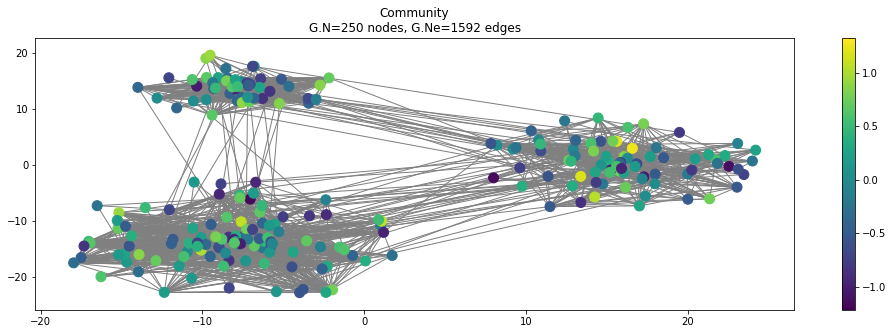

In [19]:
G.plot_signal(x_div)

In the PyGSP, the gradient and divergence can be computed more efficiently with `G.grad()` and `G.div()`.

In [20]:
np.testing.assert_allclose(x_grad, G.grad(x))
np.testing.assert_allclose(x_div, G.div(x_grad))

### 3.2 Smoothness

Is our random signal smooth? Our intuition certainly says no. Let's verify by computing the norm of the gradient:
$$\| \nabla_\G \, \x \|_2^2 = \langle \D \x, \D \x \rangle = \x^\intercal \L \x = \sum_{i \sim j} \W[i,j] (\x[i] - \x[j])^2.$$

Note that we are normalizing by the norm of the signal, so that its energy does not influence our computation.

In [21]:
x.T @ G.L @ x / np.linalg.norm(x)**2

0.98305150610148584

Let's compare it with the partitioning function:
$$ x[i] =
\begin{cases}
    -1 &\text{if } i \in S_1, \\
    0  &\text{if } i \in S_2, \\
    1  &\text{if } i \in S_3,
\end{cases}
$$
where $S_i$ is the set of nodes in partition $i$.

In [22]:
x = np.zeros(G.N)
x[:communities[0]] = -1 * np.ones(communities[0])
x[-communities[-1]:] = 1 * np.ones(communities[-1])

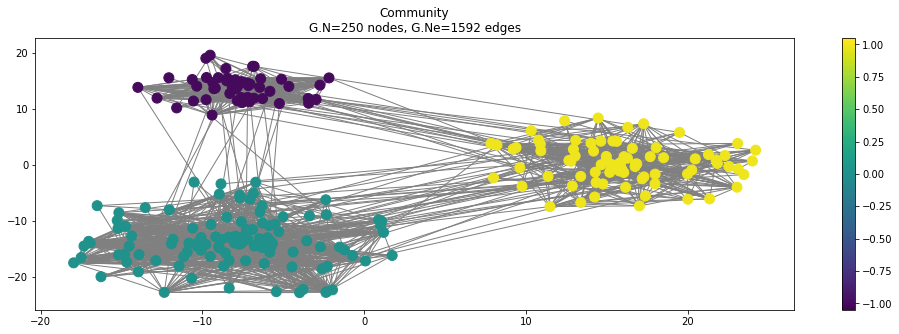

In [23]:
G.plot_signal(x)

In [24]:
x.T @ G.L @ x / np.linalg.norm(x)**2

0.1612130894791956

That function is certainly smoother!

### 3.3 Exercise

Find the smoothest non-trivial signal
$$\x^\star = \argmin_{\x \in \R^N} \x^\intercal \L \x, \ \text{ s.t. } \ \x \neq \mathbf{0} \ \text{ and } \ \x^\intercal \D^{1/2} \mathbf{1} = 0,$$
where $\mathbf{0}$ denotes the vector of all zeroes, and $\mathbf{1}$ the vector of all ones. The first constraint prevents the solution to be the zero vector, while the second constraint forces it to be orthogonal to the first eigenvector. The first eigenvector is $\frac{1}{N} \mathbf{1}$ for the combinatorial Laplacian and $\D^{1/2} \mathbf{1}$ for the normalized Laplacian.

In [25]:
# Not the null signal.
x0 = np.zeros(G.N)
x0.T @ G.L @ x0

0.0

In [26]:
# Not the "constant" signal either.
if G.lap_type == 'combinatorial':
    x1 = np.ones(G.N)
elif G.lap_type == 'normalized':
    x1 = np.power(G.d, 0.5) * np.ones(G.N)

x1.T @ G.L @ x1

-1.9188681599382527e-13

In [27]:
# Solution: the second eigenvector.
x = sparse.linalg.eigsh(G.L, k=2, which='SM')[1][:, 1]

print(x.T @ x1)
x.T @ G.L @ x / np.linalg.norm(x)**2

5.76379222128e-14


0.034072173371493576

## 4 Fourier basis

The Fourier basis is defined as $\U = [\u_1, \ldots, \u_N] \in \R^{N \times N}$, where the columns of $\U$ are the eigenvectors of the graph Laplacian $\L$. It can be computed with the PyGSP by the `compute_fourier_basis()` method. Remember that this involves the full eigendecomposition of the Laplacian $\L = \U \mathbf{\Lambda} \U^\intercal$ which costs $\mathcal{O}(N^3)$ operations in general.

As expected, the Fourier basis of a ring graph is equivalent to the classical Fourier modes:

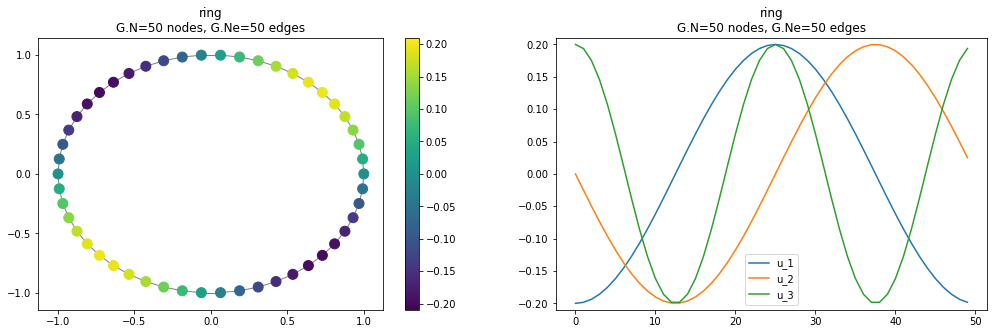

In [28]:
G = graphs.Ring(N=50)
G.compute_fourier_basis()

fig, axes = plt.subplots(1, 2)
G.plot_signal(G.U[:, 4], ax=axes[0])

G.set_coordinates('line1D')
G.plot_signal(G.U[:, 1:4], ax=axes[1])
axes[1].legend(['u_{}'.format(i) for i in range(1, 4)]);

From the eigenvalue equation, we can write
$$\L \u_n = \lambda_n \u_n \ \Leftrightarrow \ \u_n^\intercal \L \u_n = \lambda_n.$$
Hence, the eigenvalues are a measure of smoothness, or frequency, of the eigenvectors.

In [ ]:
def print_eigenvalue(n):
    u = G.U[:, n]
    print('u_{0}^T L u_{0} = {1:.4f} (eigenvalue {2:.4f})'.format(n, u.T @ G.L @ u, G.e[n]))

for n in range(6):
    print_eigenvalue(n)

### 4.1 Exercise

Plot the first 7 Fourier modes, i.e. $\u_1$ to $\u_7$, of the grid and a sensor network. What do you observe?

**Your answer here.** The eigenvectors can be localized on non-regularly sampled graphs.

Hints:
* Use `G = graphs.Grid2d(10, 10)` and `G = graphs.Sensor(seed=42)`.

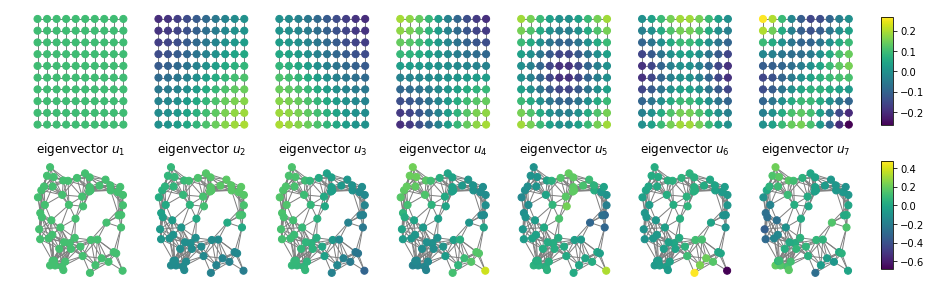

In [29]:
fig, axes = plt.subplots(2, 7)

G = graphs.Grid2d(10, 10)
G.compute_fourier_basis()
limits = [f(G.U[:, :len(axes[0, :])]) for f in (np.min, np.max)]
for i, ax in enumerate(axes[0, :]):
    G.plot_signal(G.U[:, i], limits=limits, colorbar=False, vertex_size=50, ax=ax)
    ax.set_title('')
    ax.set_axis_off()
fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.82, 0.56, 0.01, 0.3])
fig.colorbar(ax.collections[0], cax=cax)

G = graphs.Sensor(seed=42)
G.compute_fourier_basis()
limits = [f(G.U[:, :len(axes[1, :])]) for f in (np.min, np.max)]
for i, ax in enumerate(axes[1, :]):
    G.plot_signal(G.U[:, i], limits=limits, colorbar=False, vertex_size=50, ax=ax)
    ax.set_title('eigenvector $u_{}$'.format(i+1))
    ax.set_axis_off()
fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.82, 0.16, 0.01, 0.3])
fig.colorbar(ax.collections[0], cax=cax);

### 4.2 Graph Fourier Transform

The graph Fourier transform (GFT, `G.gft()`) of a signal $\x$ is given by
$$\hat\x = \mathcal{F}\{\x\} = \U^\intercal \x \in \R^N,$$
where $\U$ is the graph Fourier basis. The reponse at "frequency" $\lambda_i$ is given by
$$\hat{\x}[i] = \langle \u_i, \x \rangle.$$

The inverse Fourier transform (`G.igft()`) is given by
$$\x = \mathcal{F}^{-1}\{\hat\x\} = \U \hat\x \in \R^N.$$

The intuition about the smoothness of a signal and its representation in the spectral domain again transfers from classical Fourier analysis. Look a the below figures.

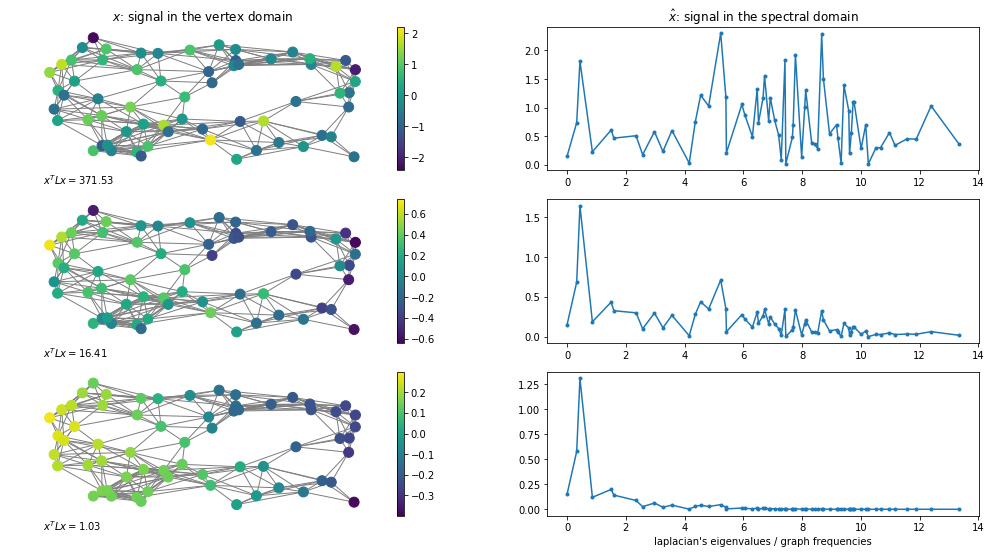

In [30]:
G = graphs.Sensor(seed=42)
G.compute_fourier_basis()

taus = [0, 3, 10]
fig, axes = plt.subplots(len(taus), 2, figsize=(17, 9))

x0 = np.random.RandomState(1).normal(size=G.N)
for i, tau in enumerate(taus):
    g = filters.Heat(G, tau)
    x = g.filter(x0).squeeze()
    x_hat = G.gft(x).squeeze()
    
    G.plot_signal(x, ax=axes[i, 0])
    axes[i, 0].set_axis_off()
    axes[i, 0].set_title('')
    axes[i, 0].text(0, -0.2, '$x^T L x = {:.2f}$'.format(x.T @ G.L @ x))
    
    axes[i, 1].plot(G.e, np.abs(x_hat), '.-')
    
axes[0, 0].set_title(r'$x$: signal in the vertex domain')
axes[0, 1].set_title(r'$\hat{x}$: signal in the spectral domain')
axes[-1, 1].set_xlabel("laplacian's eigenvalues / graph frequencies");

## 5 Filtering

A graph signal $\x$ is filtered as
$$\y = \U \g(\mathbf{\Lambda}) \U^\intercal \, \x = \g(\U \mathbf{\Lambda} \U^\intercal) \, \x = \g(\L) \, \x,$$
where $\g(\cdot)$ is the filter kernel defined in the specral domain as a function of the eigenvalues ("frequencies").

In general, we try to avoid the Fourier basis because of the $\O(N^3)$ incured cost of the eigendecomposition, to be added to the $\O(N^2)$ cost of each filtering operation. Defining filters as polynomials of the graph Laplacian, i.e.
$$\g(\L) = \sum_{k=0}^K \theta_k \L^k$$
solves this problem as we can compute
$$
\begin{align*}
\bar\x_0 &= \L^0 \x = \x, \\
\bar\x_1 &= \L^1 \x = \L \x_0, \\
\bar\x_2 &= \L^2 \x = \L \x_1, \\
\bar\x_k &= \L^k \x = \L \x_{k-1}.
\end{align*}
$$
The filtered signal is then
$$ \y = \hat{g}(\L) \, \x = \sum_{k=0}^K \theta_k \bar\x_k, $$
for a computational cost of $\O(K N)$, as $|\E| \propto N$ for sparse graphs.

As long as you can specify your filter $\g(\cdot)$ as a continuous function of the eigenvalues $\lambda$, the PyGSP will take care of computing the coefficients of the best approximating [Chebyshev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials) or order $K$, then use those to perform the filtering operation.

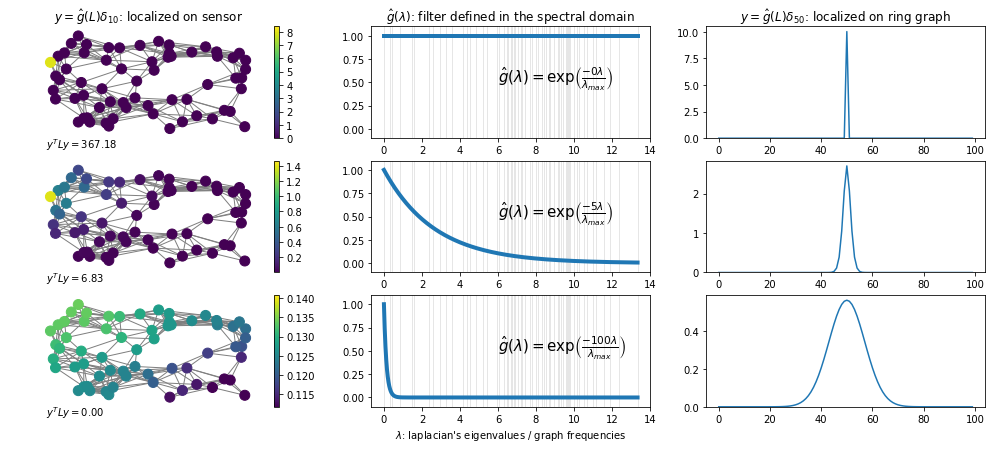

In [31]:
G1 = graphs.Sensor(seed=42)
G1.compute_fourier_basis()
G2 = graphs.Ring(N=100)
G2.compute_fourier_basis()
G2.set_coordinates('line1D')

TAUS = [0, 5, 100]
DELTA = 10

fig, axes = plt.subplots(len(TAUS), 3, figsize=(17, 7))

for i, tau in enumerate(TAUS):
    g1 = filters.Heat(G1, tau)
    g2 = filters.Heat(G2, tau)
    
    y = g1.localize(DELTA).squeeze()
    G1.plot_signal(y, ax=axes[i, 0])
    axes[i, 0].set_axis_off()
    axes[i, 0].set_title('')
    axes[i, 0].text(0, -0.2, '$y^T L y = {:.2f}$'.format(y.T @ G1.L @ y))
    
    G2.plot_signal(g2.localize(G2.N//2), ax=axes[i, 2])
    axes[i, 2].set_title('')
    
    g1.plot(ax=axes[i, 1])
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('')
    axes[i, 1].set_ylim(-0.1, 1.1)
    text = r'$\hat{{g}}(\lambda) = \exp \left( \frac{{-{{{}}} \lambda}}{{\lambda_{{max}}}} \right)$'.format(tau)
    axes[i, 1].text(6, 0.5, text, fontsize=15)
    
axes[0, 0].set_title('$y = \hat{{g}}(L) \delta_{{{}}}$: localized on sensor'.format(DELTA))
axes[0, 1].set_title('$\hat{g}(\lambda)$: filter defined in the spectral domain')
axes[0, 2].set_title('$y = \hat{{g}}(L) \delta_{{{}}}$: localized on ring graph'.format(G2.N//2))
axes[-1, 1].set_xlabel("$\lambda$: laplacian's eigenvalues / graph frequencies");

### 5.1 Exercise: analysis and synthesis

Some tasks in [signal processing](https://en.wikipedia.org/wiki/Signal_processing), for example compression or coding, involves the analysis (the decomposition) of a signal $\x_1 \in \R^N$ with a [filter bank](https://en.wikipedia.org/wiki/Filter_bank), i.e. a set of $N_f$ filters. We can see it as the decomposition of the signal into a set of $N_f$ signals $\x_2 \in \R^{N \times N_f}$, each being a response to a filter extracting a particular feature (e.g. a frequency band or a particular 2D texture). On the other end, we want to reconstruct the signal $\x_3 \in \R^N$ from $\x_2$, after possibly a transmission or compression. Our goal is to minimize some reconstruction error $d(\x_3, \x_1)$. The error could for example be the perceived visual loss for image compression.

Look at the below code, where $\x_1 = \delta_{13}$. We analyze it with two filter banks (`filters.MexicanHat` and `filters.Itersine`) of `Nf=4` filters and then synthesize $\x_3$. How do you explain the difference in reconstruction error $d(\x_3, \x_1) = \| \x_1 - \x_3 \|_2$ between both filter banks?

Hints:
* Look at the frequency response of the filter banks.

In [32]:
G = graphs.Sensor(30, seed=42)
G.compute_fourier_basis()  # Reproducible computation of lmax.
s1 = np.zeros(G.N)
s1[13] = 1

In [33]:
g = filters.MexicanHat(G, Nf=4)
s2 = g.analyze(s1)
s3 = g.synthesize(s2)
np.linalg.norm(s1 - s3)

0.87615920695299354

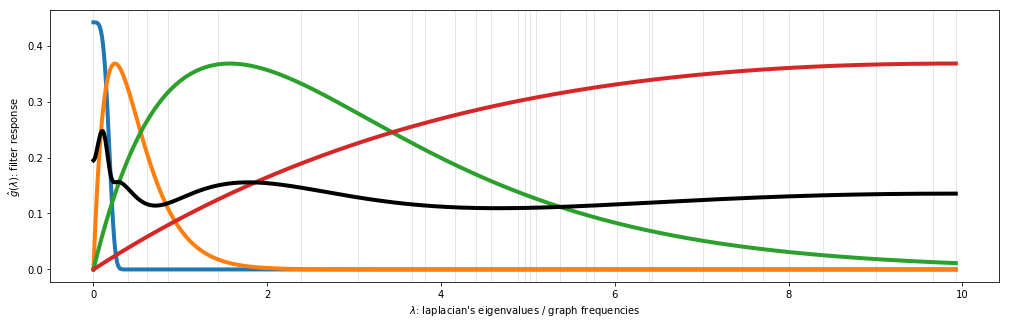

In [34]:
g.plot()

In [35]:
g = filters.Itersine(G, Nf=4)
s2 = g.analyze(s1)
s3 = g.synthesize(s2)
np.linalg.norm(s1 - s3)

0.00043944963709390808

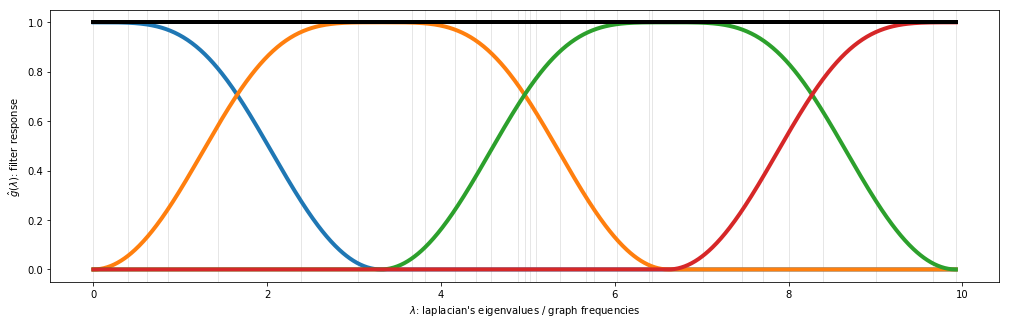

In [36]:
g.plot()

**Your answer here.** The `Itersine` filter bank is a [tight frame](https://en.wikipedia.org/wiki/Frame_%28linear_algebra%29#Tight_frames). It is therefore preserving all the information about $\x_1$, while the `MexicanHat` filter bank is loosing some. Look at how the sum of all filters, the black line in the above plots, is the identity function for the `Itersine` filter bank.